In [1]:
import os
from pathlib import Path
import torch
import numpy as np
from omegaconf import OmegaConf
from train_model_coco_dualenc_new import get_models
from analysis import rsa, cka
import matplotlib.pyplot as plt
from scipy.spatial.distance import squareform

from torchvision import transforms
from data_module import MyDataModule
from model_module import LitMML

ModuleNotFoundError: No module named 'train_model_coco_dualenc_new'

In [2]:
config_str = """
model:
  image_encoder_name : 'google/vit-base-patch16-224'
  text_encoder_name : 'google-bert/bert-base-uncased'
  tokenizer :
    use_fast: False


dataset:
  train:
    - 'coco'
    - 'vg'
    - 'cc3m'
  val:
    - 'coco_val'
    - 'cifar10'
    - 'caltech101'
  transforms: 
    enabled: True #False #True
    RandAugment:
      num_ops: 3
      magnitude: 8
  max_seq_length: 72
  coco:
    root: '/pfss/mlde/workspaces/mlde_wsp_PI_Roig/shared/datasets/COCO'
    split_train : '/pfss/mlde/workspaces/mlde_wsp_PI_Roig/bhavin/students/phillipscholl/multimodal/my_datasets/coco_karpathy_train.json'
    split_val : '/pfss/mlde/workspaces/mlde_wsp_PI_Roig/bhavin/students/phillipscholl/multimodal/my_datasets/coco_karpathy_val.json'
    split_test : '/pfss/mlde/workspaces/mlde_wsp_PI_Roig/bhavin/students/phillipscholl/multimodal/my_datasets/coco_karpathy_test.json'
  vg:
    data_dir: '/pfss/mlde/workspaces/mlde_wsp_PI_Roig/shared/datasets/VG_Bhavin/VG'
  cc3m:
    data_dir: '/pfss/mlde/workspaces/mlde_wsp_PI_Roig/shared/datasets/CC3m/h5'
  cifar10:
    root: '/pfss/mlde/workspaces/mlde_wsp_PI_Roig/shared/datasets/cifar10'
    download: false
  caltech101 :
    root: '/pfss/mlde/workspaces/mlde_wsp_PI_Roig/shared/datasets/caltech101'
    download: false
  use_subset:
    value: true
    subset_fraction: 1.0 
  use_subset_probe:
    value: false
    subset_fraction: 1.0
    

dataloader:
  train:
    shuffle : True
    batch_size : 512 #512 #1024 #512 #1792 #1920 #2048 #256 #512 #1536 #2048  #896 #960 #1024 #256 #180
    #batch_size : 192
    num_workers: 8
    persistent_workers: True
    pin_memory: True

  coco_val:
    shuffle : False
    #batch_size : 
    batch_size : 512 #512 #1024 #512 #1792 #1024 #1920 #2048 #256 #512 #1536 #896 #960 #1024 #256 #180
    num_workers : 8
    persistent_workers: True
    pin_memory: True
  
  cifar10_val:
    batch_size: 512 #512
    shuffle: False
    num_workers: 8
    persistent_workers: True
    pin_memory: True

  caltech101_val:
    batch_size: 512
    shuffle: False
    num_workers: 8
    persistent_workers: True
    pin_memory: True


loss:
  losses:
    # - 'contrastive'
    # - 'image_text_matching'
    - 'SimCLR'
  contrastive:
  #  temperature : 1.
  image_text_matching:
    arg1: ''

optimizer:
  name : "AdamW"
  lr: 2e-04
  kwargs:
    weight_decay : 0.1
    betas : [0.9, 0.95]

scheduler:
  enabled: True #True
  name: CosineWarmup
  monitor: 'loss-val'
  interval: 'step'
  kwargs:
    initial_lr: 1e-08
    num_warmup_steps: 'epoch'
    num_training_steps: 'all'


"""
config = OmegaConf.create(config_str)


SAVE_FIGURES_FIG = Path(
    "/pfss/mlde/workspaces/mlde_wsp_PI_Roig/bhavin/students/phillipscholl/multimodal/analysis/figures"
)

# model,processor = get_models(config)

# dataloaders = get_dataloaders(config, datasets=get_datasets(config, processor=processor), collate_fn=batch_input_processing_func(processor))
# # coco_val_dataloader = dataloaders['coco_val']
# cifar10_val_dataloader = dataloaders['cifar10_val']
# val_dataloaders = [coco_val_dataloader, cifar10_val_dataloader]


model, processor = get_models(config)

net = LitMML(
    model,
    processor,
    loss_cfg=config.loss,
    optimizer_cfg=config.optimizer,
    scheduler_cfg=config.scheduler,
    # augmentation=augmentation,
)

data_module = MyDataModule(
    config,
    processor,
    local_dev=False,
    augmentation=None,
    num_views=2,
)


callback_dataloaders = data_module.callback_dataloader()
cifar10_test = callback_dataloaders["cifar10_test"]

/pfss/mlde/workspaces/mlde_wsp_PI_Roig/bhavin/torchenv/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [3]:
device = torch.device("cuda:0")


def get_cifar10_reps(cifar_dataloader, forward_func):

    rep_dict = {i: [] for i in range(10)}
    for i, (img, lbl) in enumerate(cifar_dataloader):
        feats = forward_func(img.to(device)).detach()
        # print (feats.shape)
        for idx, element in enumerate(lbl.flatten()):
            assert element < 10
            rep_dict[element.item()].append(feats[idx, ...])

    return rep_dict

In [4]:
CKPT_DIR = "/pfss/mlde/workspaces/mlde_wsp_PI_Roig/bhavin/students/phillipscholl/multimodal/models/cliplike/ckpts"
INTERESTING_CHECKPOINTS = OmegaConf.load("analysis/model_info.yaml")

# INTERESTING_CHECKPOINTS = {
#     0.2 : 'n4pejzi5', # 'sunny-elevator-89',
#     0.4 : 'vnfcvlch', #'fragrant-flower-90',
#     0.6 : '0fsftphe', # 'exalted-night-92',
# }

In [5]:
REPS = {}
for key in INTERESTING_CHECKPOINTS:
    fname = os.path.join(CKPT_DIR, key, "last.ckpt")
    checkpoint = torch.load(fname, map_location="cpu")
    state_dict = {
        k[6:]: v for k, v in checkpoint["state_dict"].items() if "model." in k
    }
    model.load_state_dict(state_dict)
    model.eval().to(device)

    rep_dict = get_cifar10_reps(
        cifar10_test, lambda x: model.get_image_features(pixel_values=x)
    )

    mean_dict = [None] * len(rep_dict)
    for cifar_cateory in sorted(rep_dict):
        mean_vec = torch.stack(rep_dict[cifar_cateory]).mean(0).flatten().to(device)
        assert mean_vec.shape[0] == 512
        mean_dict[cifar_cateory] = mean_vec.cpu().numpy()

    REPS[key] = mean_dict

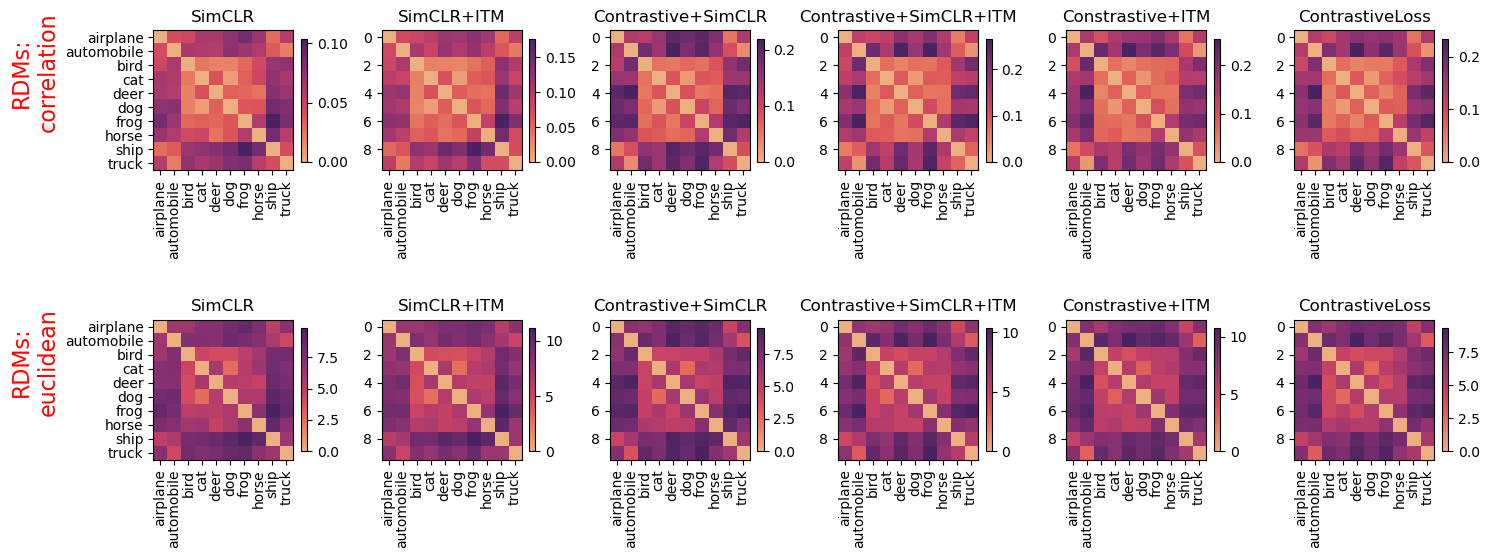

In [6]:
import seaborn as sns

# plt.style.use("seaborn-v0_8-")

METRICS_FOR_RDMS = [
    "correlation",
    "euclidean",
]

# RDM_DICT = {method: {} for method in METRICS_FOR_RDMS}

fig, axs = plt.subplots(
    len(METRICS_FOR_RDMS), len(REPS), figsize=(15, 3 * len(METRICS_FOR_RDMS))
)
fig.subplots_adjust(hspace=1.1, wspace=1.0)

for methodind, method in enumerate(METRICS_FOR_RDMS):
    axs[methodind, 0].set_ylabel(f"RDMs:\n{method}", color="red", y=0.7, fontsize=16)
    axs[methodind, 0].set_yticks(
        [x for x in range(10)], cifar10_test.dataset.class_to_idx.keys()
    )

    for keyind, key in enumerate(REPS):
        a = rsa.get_rdm(REPS[key], metric=method)
        # RDM_DICT[method][key] = a
        img = axs[methodind, keyind].imshow(
            squareform(a), cmap=sns.color_palette("flare", as_cmap=True)
        )
        plt.colorbar(img, ax=axs[methodind, keyind], fraction=0.04)
        axs[methodind, keyind].set_title(INTERESTING_CHECKPOINTS[key]["name"])
        # axs[methodind,keyind].set_yticks([x for x in range(10)],['']*10)

        axs[methodind, keyind].set_xticks(
            [x for x in range(10)],
            cifar10_test.dataset.class_to_idx.keys(),
            rotation=90,
        )
        # fig.colorbar(im,cax=axs[methodind,keyind])

plt.tight_layout()
# plt.savefig(SAVE_FIGURES_FIG / "RDMs_all_models_last_layer.png", bbox_inches="tight")

## RSA with various metrics

In [25]:
similarity_measure = [
    "pearsonr",
    "spearmanr",
    "riemann",
]


def get_rsa_matrix(similarity_measure):
    rsa_matrix = np.zeros((len(REPS), len(REPS)))
    for keyind1, key1 in enumerate(REPS):
        for keyind2, key2 in enumerate(REPS):
            rdm1 = rsa.get_rdm(REPS[key1])
            rdm2 = rsa.get_rdm(REPS[key2])

            rsaval = rsa.get_rsa(rdm1, rdm2, similarity_measure=similarity_measure)
            # print (rsaval)
            if similarity_measure != "riemann":
                rsa_matrix[keyind1, keyind2] = rsaval.statistic
            else:
                rsa_matrix[keyind1, keyind2] = rsaval

    return rsa_matrix

Since the args are already rdms, converting them into rsms
Since the args are already rdms, converting them into rsms
Since the args are already rdms, converting them into rsms
Since the args are already rdms, converting them into rsms
Since the args are already rdms, converting them into rsms
Since the args are already rdms, converting them into rsms
Since the args are already rdms, converting them into rsms
Since the args are already rdms, converting them into rsms
Since the args are already rdms, converting them into rsms
Since the args are already rdms, converting them into rsms
Since the args are already rdms, converting them into rsms
Since the args are already rdms, converting them into rsms
Since the args are already rdms, converting them into rsms
Since the args are already rdms, converting them into rsms
Since the args are already rdms, converting them into rsms
Since the args are already rdms, converting them into rsms
Since the args are already rdms, converting them into rs

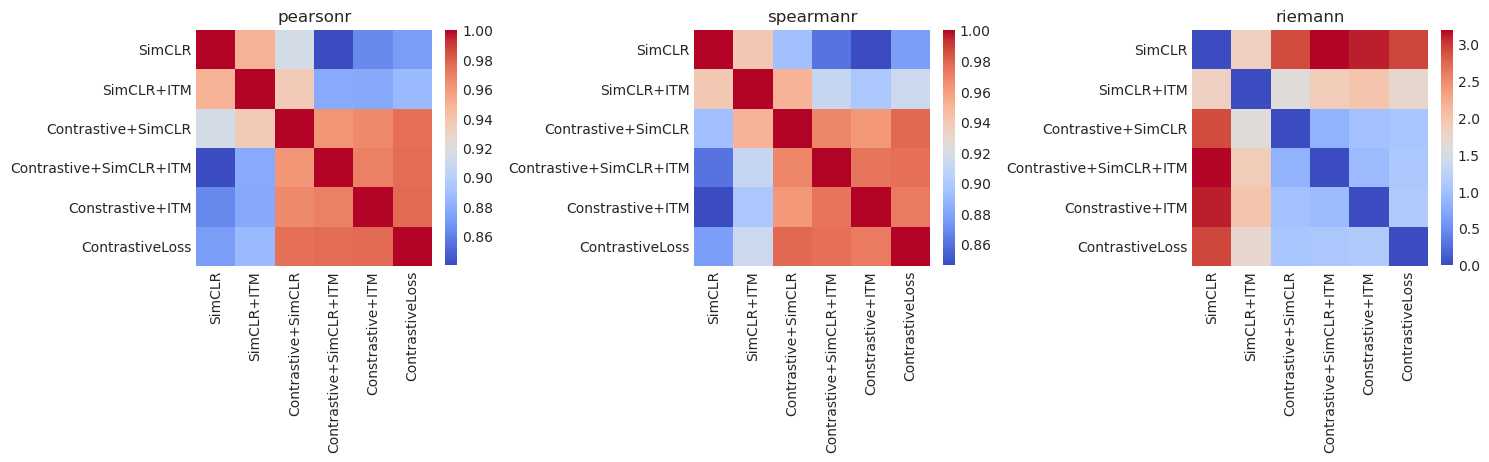

In [26]:
plt.style.use("seaborn-v0_8-dark")
plt.figure(figsize=(15, 5))
for sind, sim in enumerate(similarity_measure):
    plt.subplot(1, 3, sind + 1)
    plt.title(sim)
    rsa_matrix = get_rsa_matrix(similarity_measure=sim)
    plt.imshow(rsa_matrix, cmap="coolwarm")
    plt.yticks(
        [x for x in range(6)], [INTERESTING_CHECKPOINTS[k]["name"] for k in REPS.keys()]
    )
    plt.xticks(
        [x for x in range(6)],
        [INTERESTING_CHECKPOINTS[k]["name"] for k in REPS.keys()],
        rotation=90,
    )
    plt.colorbar(fraction=0.045)

plt.tight_layout()
plt.savefig(
    SAVE_FIGURES_FIG / "RSA_across_all_models_last_layer.png", bbox_inches="tight"
)

Since the args are already rdms, converting them into rsms
Since the args are already rdms, converting them into rsms
Since the args are already rdms, converting them into rsms
Since the args are already rdms, converting them into rsms
Since the args are already rdms, converting them into rsms
Since the args are already rdms, converting them into rsms
Since the args are already rdms, converting them into rsms
Since the args are already rdms, converting them into rsms
Since the args are already rdms, converting them into rsms
Since the args are already rdms, converting them into rsms
Since the args are already rdms, converting them into rsms
Since the args are already rdms, converting them into rsms
Since the args are already rdms, converting them into rsms
Since the args are already rdms, converting them into rsms
Since the args are already rdms, converting them into rsms
Since the args are already rdms, converting them into rsms
Since the args are already rdms, converting them into rs

/tmp/ipykernel_292772/3192757317.py:21: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  z = hierarchy.linkage(rsa_matrix)


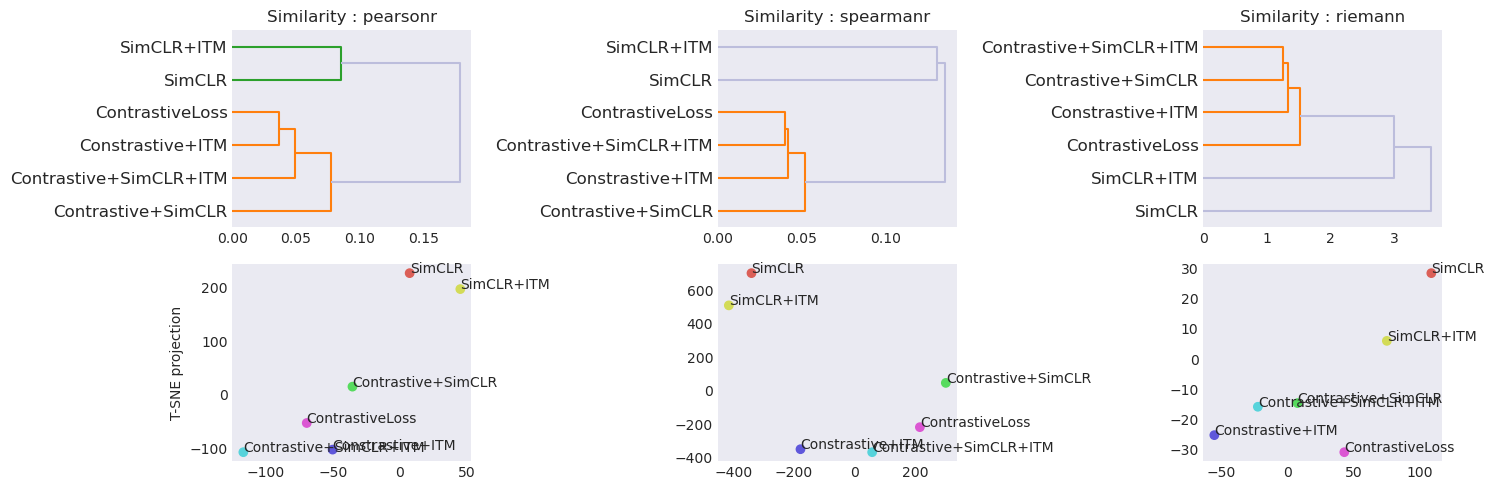

In [27]:
from scipy.cluster import hierarchy
import seaborn as sns
from sklearn.manifold import TSNE

similarity_measure = [
    "pearsonr",
    "spearmanr",
    "riemann",
]

plt.style.use("seaborn-v0_8-dark")

labels = [INTERESTING_CHECKPOINTS[k]["name"] for k in REPS.keys()]
fig, axes = plt.subplots(2, 3, figsize=(15, 5), height_ratios=[1, 1])

axes[1, 0].set_ylabel("T-SNE projection")

for sind, sim in enumerate(similarity_measure):

    rsa_matrix = get_rsa_matrix(similarity_measure=sim)
    z = hierarchy.linkage(rsa_matrix)
    dn2 = hierarchy.dendrogram(
        z,
        ax=axes[0, sind],
        above_threshold_color="#bcbddc",
        # color_threshold=1.5,
        orientation="right",
        labels=labels,
    )
    axes[0, sind].set_title(f"Similarity : {sim}")

    _perplexity = 2
    X_embedded = TSNE(
        n_components=2, learning_rate="auto", init="random", perplexity=_perplexity
    ).fit_transform(rsa_matrix)

    xs = X_embedded[:, 0]
    ys = X_embedded[:, 1]
    axes[1, sind].scatter(
        xs,
        ys,
        color=sns.color_palette("hls", 6),
    )

    xoffset = 0
    yoffset = 0
    for ind, labeltext in enumerate(labels):
        axes[1, sind].text(xs[ind] + xoffset, ys[ind] + yoffset, labeltext, rotation=0)

fig.tight_layout()
# plt.savefig(
#     SAVE_FIGURES_FIG / "RSA_dendrogram_across_all_models_last_layer.png",
#     bbox_inches="tight",
# )

In [2]:
# TODO : extend to CKA, SVCCA, etc.
# TODO : add datasets beyond cifar10
rep_dict

NameError: name 'rep_dict' is not defined

## CKA

In [10]:
CKA_REPS = {}
for key in INTERESTING_CHECKPOINTS:
    fname = os.path.join(CKPT_DIR, key, "last.ckpt")
    checkpoint = torch.load(fname, map_location="cpu")
    state_dict = {
        k[6:]: v for k, v in checkpoint["state_dict"].items() if "model." in k
    }
    model.load_state_dict(state_dict)
    model.eval().to(device)
    rep_dict = get_cifar10_reps(
        cifar10_test, lambda x: model.get_image_features(pixel_values=x)
    )
    mean_vec = (
        torch.concatenate([torch.stack(rep_dict[x]) for x in rep_dict], axis=0)
        .cpu()
        .numpy()
    )
    CKA_REPS[key] = mean_vec
    assert mean_vec.shape[0] == 10000

cka_mat = np.nan * np.zeros(
    (len(INTERESTING_CHECKPOINTS), len(INTERESTING_CHECKPOINTS))
)
kernel_mat = np.nan * np.zeros(
    (len(INTERESTING_CHECKPOINTS), len(INTERESTING_CHECKPOINTS))
)
for k1ind, key1 in enumerate(CKA_REPS):
    for k2ind, key2 in enumerate(CKA_REPS):
        if np.isnan(cka_mat[k2ind, k1ind]) == True:
            ckaval = cka.linear_CKA(CKA_REPS[key1], CKA_REPS[key2])
            cka_mat[k1ind, k2ind] = ckaval
            cka_mat[k2ind, k1ind] = ckaval

            kernelckaval = cka.kernel_CKA(CKA_REPS[key1], CKA_REPS[key2])
            kernel_mat[k1ind, k2ind] = kernelckaval
            kernel_mat[k2ind, k1ind] = kernelckaval

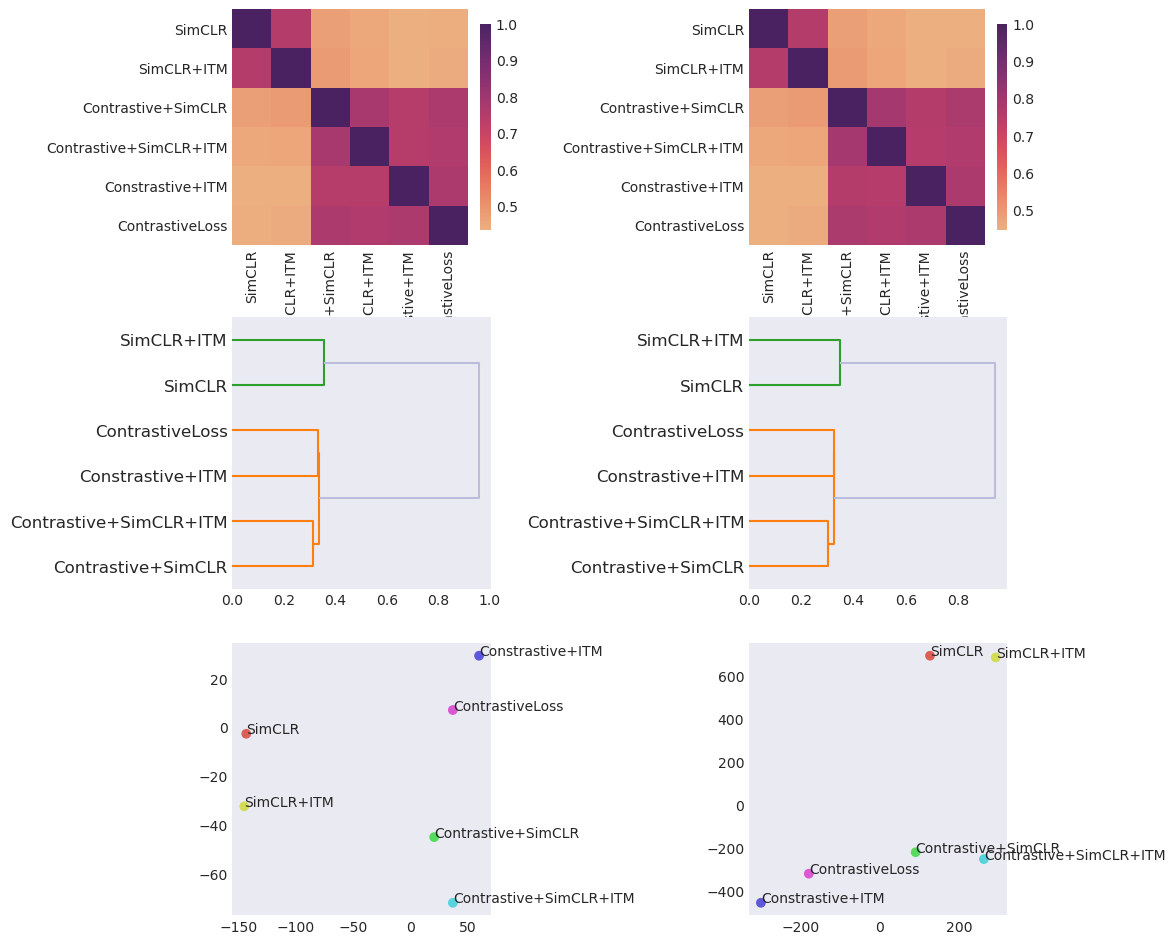

In [11]:
import seaborn as sns
from scipy.cluster import hierarchy
import seaborn as sns
from sklearn.manifold import TSNE
plt.style.use("seaborn-v0_8-dark")


fig, axs = plt.subplots(3, 2, figsize=(10, 12))
fig.subplots_adjust(wspace=1.0)

labels = [INTERESTING_CHECKPOINTS[k]["name"] for k in CKA_REPS.keys()]

for sind, rsa_matrix in enumerate([cka_mat, kernel_mat]):

    img = axs[0, sind].imshow(rsa_matrix, cmap=sns.color_palette("flare", as_cmap=True))
    plt.colorbar(img, ax=axs[0, sind], fraction=0.04)

    axs[0, sind].set_yticks([x for x in range(6)], labels)
    axs[0, sind].set_xticks([x for x in range(6)], labels, rotation=90)

    z = hierarchy.linkage(rsa_matrix)
    dn2 = hierarchy.dendrogram(
        z,
        ax=axs[1, sind],
        above_threshold_color="#bcbddc",
        # color_threshold=1.5,
        orientation="right",
        labels=labels,
    )

    _perplexity = 2
    X_embedded = TSNE(
        n_components=2, learning_rate="auto", init="random", perplexity=_perplexity
    ).fit_transform(rsa_matrix)

    xs = X_embedded[:, 0]
    ys = X_embedded[:, 1]
    axs[2, sind].scatter(
        xs,
        ys,
        color=sns.color_palette("hls", 6),
    )

    xoffset = 0
    yoffset = 0
    for ind, labeltext in enumerate(labels):
        axs[2, sind].text(xs[ind] + xoffset, ys[ind] + yoffset, labeltext, rotation=0)


# fig.tight_layout()
plt.savefig(
    SAVE_FIGURES_FIG / "CKA_across_all_models_last_layer.png", bbox_inches="tight"
)

In [ ]:
colors = sns.color_palette("hls", 10)
labels = []
for x in range(10):
    labels += [colors[x]] * 1000

fig, axs = plt.subplots(len(CKA_REPS), 5, figsize=(5 * 5, len(CKA_REPS) * 5))
fig.suptitle(INTERESTING_CHECKPOINTS["93t3xgrr"])

for keyind, key in CKA_REPS:
    X = CKA_REPS[key]
    axs[keyind, 0].set_xlabel(INTERESTING_CHECKPOINTS[key]["name"])
    for ind, _perplexity in enumerate([5, 10, 20, 50, 100]):
        X_embedded = TSNE(
            n_components=2,
            learning_rate="auto",
            init="pca",
            perplexity=_perplexity,
        ).fit_transform(X)

        xs = X_embedded[:, 0]
        ys = X_embedded[:, 1]

        axs[keyind, ind].scatter(xs, ys, color=labels)
        axs[keyind, ind].set_title(_perplexity)

# Linear Probe Figure

['SimCLR', 'SimCLR+ITM', 'Contrastive+SimCLR', 'Contrastive+SimCLR+ITM', 'Constrastive+ITM', 'ContrastiveLoss']


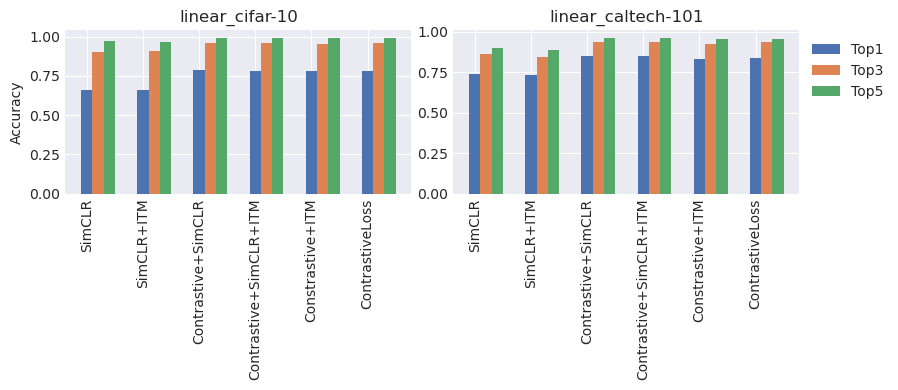

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import seaborn as sns


# with open('/pfss/mlde/workspaces/mlde_wsp_PI_Roig/bhavin/students/phillipscholl/multimodal/zero_shot_results.p','rb') as f:
# data = pickle.load(f)
with open(
    "/pfss/mlde/workspaces/mlde_wsp_PI_Roig/bhavin/students/phillipscholl/multimodal/analysis/data/linear_results.p",
    "rb",
) as f:
    data = pickle.load(f)


plt.style.use("seaborn-v0_8-darkgrid")

colors = sns.color_palette("deep", 3)

fig, axs = plt.subplots(1, 2, figsize=(9, 4))

width = 0.2
xs = list(data.keys())
sortidx = [0, 2, 4, 5, 3, 1]
xs = [xs[s] for s in sortidx]
print(xs)
indices = np.arange(len(xs))

axs[0].set_ylabel("Accuracy")
for dind, dataset in enumerate(["linear_cifar-10", "linear_caltech-101"]):

    axs[dind].set_title(dataset)

    ys = [data[x][dataset]["Top1Accuracy"] for x in xs]
    axs[dind].bar(indices, ys, width=width, color=colors[0], label="Top1")
    # axs[dind].set_xticks([i for i in range(len(xs))],xs,rotation=90)

    ys = [data[x][dataset]["Top3Accuracy"] for x in xs]
    axs[dind].bar(indices + width, ys, width=width, color=colors[1], label="Top3")
    axs[dind].set_xticks(indices + width, xs, rotation=90)

    ys = [data[x][dataset]["Top5Accuracy"] for x in xs]
    axs[dind].bar(indices + width * 2, ys, width=width, color=colors[2], label="Top5")
    axs[dind].set_xticks([i for i in range(len(xs))], xs, rotation=90)

plt.legend(bbox_to_anchor=(1, 1))
fig.tight_layout()
# plt.savefig(
#     SAVE_FIGURES_FIG / "LinearProbe_all_models_last_layer.png", bbox_inches="tight"
# )

## Zeroshot Figure

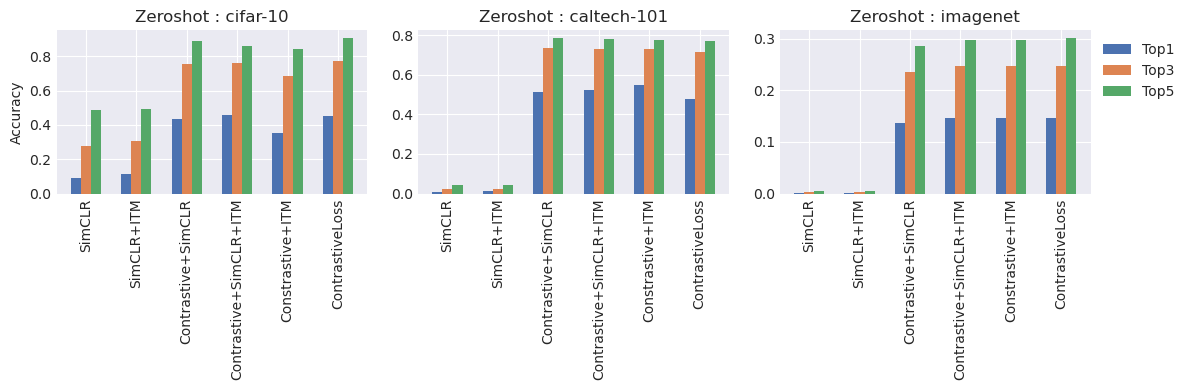

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import seaborn as sns

fname = "/pfss/mlde/workspaces/mlde_wsp_PI_Roig/bhavin/students/phillipscholl/multimodal/analysis/data/combined_zero_shot_results.p"
with open(fname, "rb") as f:
    data = pickle.load(f)

plt.style.use("seaborn-v0_8-darkgrid")
colors = sns.color_palette("deep", 3)
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

width = 0.2
xs = list(data.keys())
indices = np.arange(len(xs))

axs[0].set_ylabel("Accuracy")
for dind, dataset in enumerate(["cifar-10", "caltech-101", "imagenet"]):

    # if dataset == 'cifar-10':
    #     axs[0].axhline(0.1,linestyle='dashed',color='gray')
    # if dataset == 'cifar-10':
    #     axs[1].axhline(0.01,linestyle='dashed',color='gray')

    axs[dind].set_title(f"Zeroshot : {dataset}")

    ys = [data[x][dataset]["Top1Accuracy"] for x in xs]
    axs[dind].bar(indices, ys, width=width, color=colors[0], label="Top1")
    # axs[dind].set_xticks([i for i in range(len(xs))],xs,rotation=90)

    ys = [data[x][dataset]["Top3Accuracy"] for x in xs]
    axs[dind].bar(indices + width, ys, width=width, color=colors[1], label="Top3")
    axs[dind].set_xticks(indices + width, xs, rotation=90)

    ys = [data[x][dataset]["Top5Accuracy"] for x in xs]
    axs[dind].bar(indices + width * 2, ys, width=width, color=colors[2], label="Top5")
    # axs[dind].set_xticks([i for i in range(len(xs))],xs,rotation=90)

plt.legend(bbox_to_anchor=(1, 1))
fig.tight_layout()

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import seaborn as sns

fname = "/pfss/mlde/workspaces/mlde_wsp_PI_Roig/bhavin/students/phillipscholl/multimodal/zathvtrx_intermediate_all_datasets.p"
fname = '/pfss/mlde/workspaces/mlde_wsp_PI_Roig/bhavin/students/phillipscholl/multimodal/93t3xgrr_intermediate_all_datasets.p'
with open(fname, "rb") as f:
    data = pickle.load(f)

In [25]:
INTERESTING_CHECKPOINTS

{'zathvtrx': {'name': 'SimCLR', 'color': 'black'}, '9v1wy0vb': {'name': 'SimCLR+ITM', 'color': 'blue'}, 'oc0g8fql': {'name': 'Contrastive+SimCLR', 'color': 'green'}, '9nvg456i': {'name': 'Contrastive+SimCLR+ITM', 'color': 'orange'}, '93t3xgrr': {'name': 'Constrastive+ITM', 'color': 'pink'}, 'yh1adr3g': {'name': 'ContrastiveLoss', 'color': 'red'}}

In [33]:
data.keys()

dict_keys(['Caltech101', 'CIFAR10', 'CIFAR100', 'DTD', 'OxfordsIIITPet', 'StanfordCars', 'FGVCAircraft', 'Food101', 'STL10'])

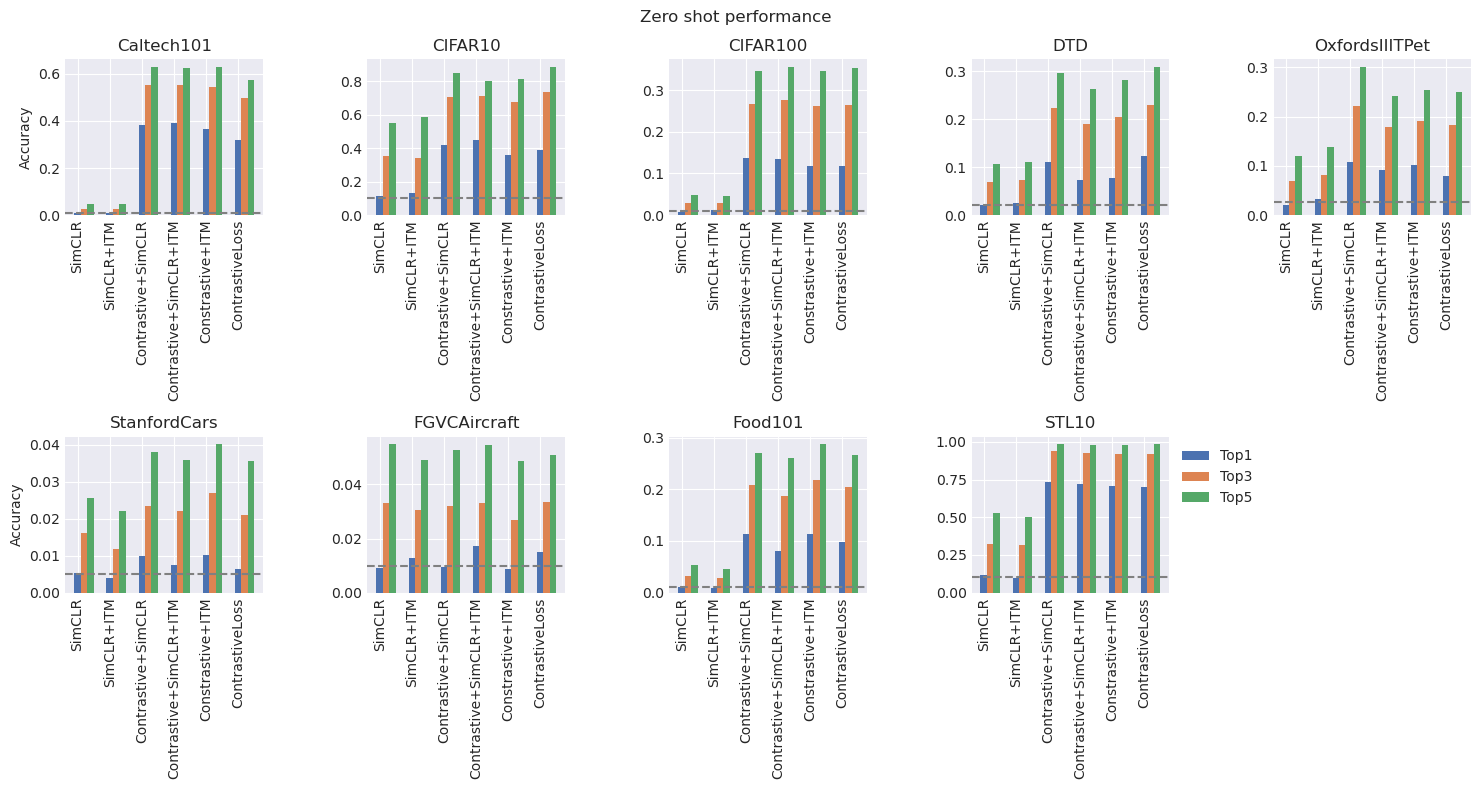

In [56]:
available_models = {}
for model in INTERESTING_CHECKPOINTS:
    fname = Path(f"/pfss/mlde/workspaces/mlde_wsp_PI_Roig/bhavin/students/phillipscholl/multimodal/{model}_intermediate_all_datasets.p")
    if fname.exists() == False:
        continue

    with open(fname, "rb") as f:
        data = pickle.load(f)
        available_models[model] = data
    
    
plt.style.use("seaborn-v0_8-darkgrid")
colors = sns.color_palette("deep", 3)
fig,axs = plt.subplots(2,5,figsize=(15,8))

baselines = {
    'Caltech101':1/101.,
    'CIFAR10':1/10.,
    'CIFAR100':1/100.,
    'DTD':1/47.,
    'OxfordsIIITPet':1./37 ,
    'StanfordCars': 1./196,
    'FGVCAircraft' : 1./102,
    'Food101': 1./101,
    'STL10': 1./10,
}

fig.suptitle('Zero shot performance')
axs[0,0].set_ylabel('Accuracy')
axs[1,0].set_ylabel('Accuracy')

fig.delaxes(axs[1,-1])


width = 0.2
for datasetind,dataset in enumerate(data):
    xs = [m for m in available_models]
    xsplot = np.arange(len(xs))
    ys1 = [available_models[m][dataset]['Top1Accuracy'] for m in xs]
    ys3 = [available_models[m][dataset]['Top3Accuracy'] for m in xs]
    ys5 = [available_models[m][dataset]['Top5Accuracy'] for m in xs]
    axs.flat[datasetind].set_title(dataset)
    axs.flat[datasetind].bar(xsplot,ys1,width=width,color=colors[0],label='Top1')
    axs.flat[datasetind].bar(xsplot+width,ys3,width=width,color=colors[1],label='Top3')
    axs.flat[datasetind].bar(xsplot+width*2,ys5,width=width,color=colors[2],label='Top5')
    
    
    axs.flat[datasetind].axhline(baselines[dataset],linestyle='dashed',color='gray')
    axs.flat[datasetind].set_xticks(np.arange(len(xs)),[INTERESTING_CHECKPOINTS[m]['name'] for m in available_models],rotation=90)
plt.legend(bbox_to_anchor=(1,1))
fig.tight_layout()


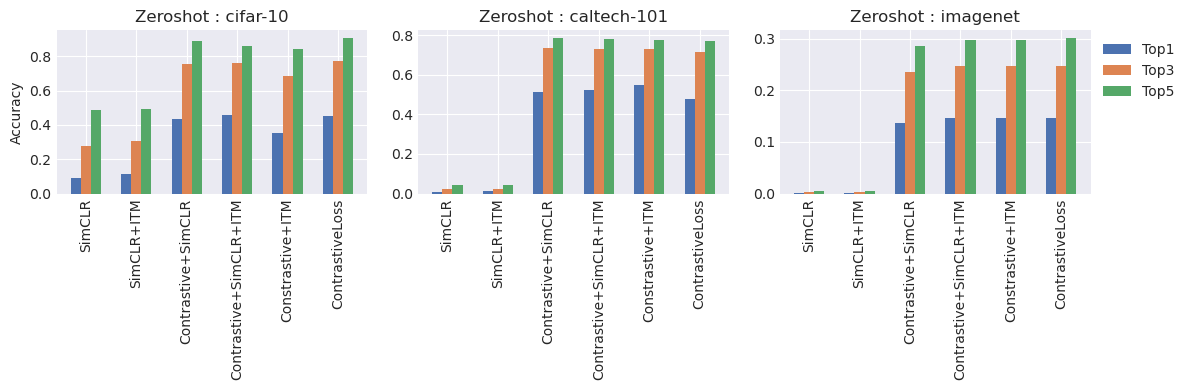

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import seaborn as sns

fname = "/pfss/mlde/workspaces/mlde_wsp_PI_Roig/bhavin/students/phillipscholl/multimodal/analysis/data/combined_zero_shot_results.p"
with open(fname, "rb") as f:
    data = pickle.load(f)

plt.style.use("seaborn-v0_8-darkgrid")
colors = sns.color_palette("deep", 3)
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

width = 0.2
xs = list(data.keys())
indices = np.arange(len(xs))

axs[0].set_ylabel("Accuracy")
for dind, dataset in enumerate(["cifar-10", "caltech-101", "imagenet"]):

    # if dataset == 'cifar-10':
    #     axs[0].axhline(0.1,linestyle='dashed',color='gray')
    # if dataset == 'cifar-10':
    #     axs[1].axhline(0.01,linestyle='dashed',color='gray')

    axs[dind].set_title(f"Zeroshot : {dataset}")

    ys = [data[x][dataset]["Top1Accuracy"] for x in xs]
    axs[dind].bar(indices, ys, width=width, color=colors[0], label="Top1")
    # axs[dind].set_xticks([i for i in range(len(xs))],xs,rotation=90)

    ys = [data[x][dataset]["Top3Accuracy"] for x in xs]
    axs[dind].bar(indices + width, ys, width=width, color=colors[1], label="Top3")
    axs[dind].set_xticks(indices + width, xs, rotation=90)

    ys = [data[x][dataset]["Top5Accuracy"] for x in xs]
    axs[dind].bar(indices + width * 2, ys, width=width, color=colors[2], label="Top5")
    # axs[dind].set_xticks([i for i in range(len(xs))],xs,rotation=90)

plt.legend(bbox_to_anchor=(1, 1))
fig.tight_layout()

## Linear Probe for each layer

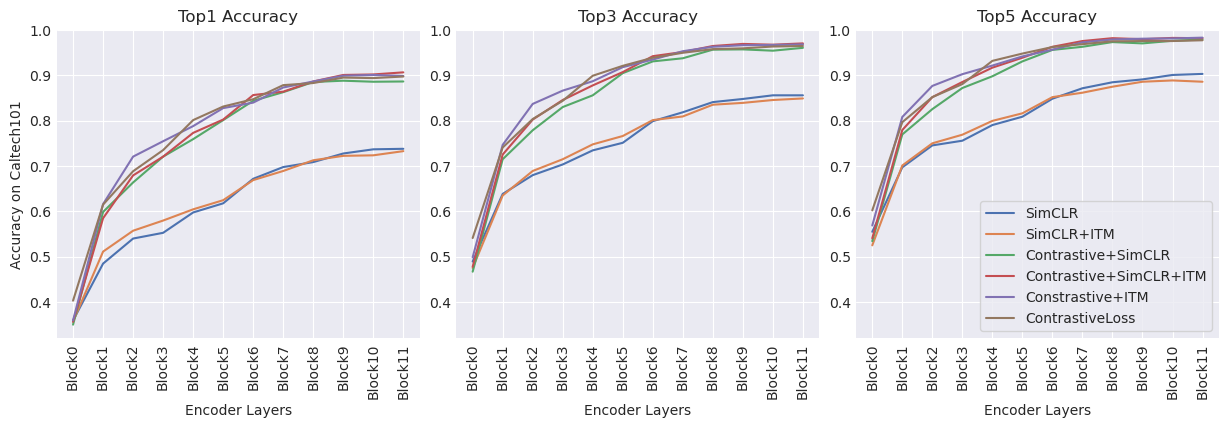

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import seaborn as sns

with open(
    "/pfss/mlde/workspaces/mlde_wsp_PI_Roig/bhavin/students/phillipscholl/multimodal/analysis/data/caltech101_layespecific_linear_results.p",
    "rb",
) as f:
    data = pickle.load(f)

plt.style.use("seaborn-v0_8-darkgrid")
colors = sns.color_palette("deep", 6)
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
fig.subplots_adjust(wspace=0.1)


layer_names = [f"encoder_layer_{i}" for i in range(12)]
xs = list(data.keys())
sortidx = [0, 2, 4, 5, 3, 1]
xs = [xs[s] for s in sortidx]


axs[0].set_title("Top1 Accuracy")
axs[1].set_title("Top3 Accuracy")
axs[2].set_title("Top5 Accuracy")
axs[0].set_xlabel("Encoder Layers")
axs[1].set_xlabel("Encoder Layers")
axs[2].set_xlabel("Encoder Layers")

axs[0].set_xticks(np.arange(12), [f"Block{x}" for x in range(12)], rotation=90)
axs[1].set_xticks(np.arange(12), [f"Block{x}" for x in range(12)], rotation=90)
axs[2].set_xticks(np.arange(12), [f"Block{x}" for x in range(12)], rotation=90)

axs[0].set_ylim(0.32, 1.0)
axs[1].set_ylim(0.32, 1.0)
axs[2].set_ylim(0.32, 1.0)

axs[0].set_ylabel("Accuracy on Caltech101")

for kind, key in enumerate(xs):
    ys = [data[key][l]["Top1Accuracy"] for l in layer_names]
    img = axs[0].plot(ys, label=key, c=colors[kind])
    # axs[0].legend()

    ys = [data[key][l]["Top3Accuracy"] for l in layer_names]
    img = axs[1].plot(ys, label=key, c=colors[kind])
    # axs[1].legend()

    ys = [data[key][l]["Top5Accuracy"] for l in layer_names]
    img = axs[2].plot(ys, label=key, c=colors[kind])
    axs[2].legend(frameon=True)